# Distinguishability of Best and Worst Matches

**March 27, 2025**

**Joshua D. Ingram**

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

from scipy.stats import ks_2samp

# Add parent directory to Python path
# Parent should be: "../starsml/"
sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())))

In [2]:
def setup_paths():
    base_path = os.path.dirname(os.path.abspath(os.getcwd()))
    return {
        'data': os.path.join(base_path, 'data'),
        'out_data': os.path.join(base_path, 'out_data')
    }

# Function to create bins with at least `min_count` values in each
def create_bins_min_count(dataframe, column, min_count=1000):
    """
    Find bin bounds with a minimum count of data in each range.

    Parameters
    ---------
    df : pd.DataFrame
        Dataframe of data.

    column : str
        Column name for column to create bins for.

    min_count : int
        Minimum count for each bin.

    Returns
    -------
    list
        List of bin bounds.
    """

    sorted_values = dataframe[column].sort_values().values
    bins = []
    current_count = 0

    # Iterate through sorted values and create bins
    for value in sorted_values:
        current_count += 1
        if current_count >= min_count:
            bins.append(value)
            current_count = 0

    # Ensure the last bin captures the max value
    if bins[-1] != sorted_values[-1]:
        bins.append(sorted_values[-1])

    # Adding the minimum value (0) to the start of the bins
    bins.insert(0, 0)

    return bins

def ks_test_filter_ranges(data1, data2, variable, filter_column1, filter_column2, 
                          filter1, filter2, filter3, filter4,
                          unique_id, filter_count = "first"):
    """
    Perform two-sample KS test on specified variable with filters.

    This function takes in two dataframes and performs a KS test on the variable
    specified. The KS test is performed on the variable for the dataframes
    filtered by the specified filters. The function returns a dataframe with the
    KS test results for each filter.

    Parameters
    ---------
    data1 : pd.DataFrame
        Dataframe of first dataset.

    data1 : pd.DataFrame
        Dataframe of second dataset.

    variable : string
        Variable of interest for filtering and analysis.

    filter_column1 : string
        Column one for first filter ranges.

    filter_column2 : string
        Column two for second filter ranges.

    filter1 : float
        Lower range for filter on filter_column1

    filter2 : float
        Upper range for filter on filter_column1

    filter3 : float
        Lower range for filter on filter_column2

    filter4 : float
        Upper range for filter on filter_column2

    filter_count : string
        Specifies which dataset to filter. Options are "first", "second", or "both".

    unique_id : string
        Unique identifier for each row in the dataframes.

    Returns
    -------
    list
        List of KS test results: [KS statistic, p-value, len(data1), len(data2)]

    """

    if filter_count == "first":
        data1 = data1[(data1[filter_column1] > filter1) & (data1[filter_column1] <= filter2) & (data1[filter_column2] > filter3) & (data1[filter_column2] <= filter4)]
        data2 = data2[data2[unique_id].isin(data1[unique_id])]
    elif filter_count == "second":
        data2 = data2[data2[filter_column1] > filter1 & data2[filter_column1] < filter2 & data2[filter_column2] > filter3 & data2[filter_column2] < filter4]
        data1 = data1[data1[unique_id].isin(data2[unique_id])]
    elif filter_count == "both":
        data1 = data1[data1[filter_column1] > filter1 & data1[filter_column1] < filter2 & data1[filter_column2] > filter3 & data1[filter_column2] < filter4]
        data2 = data2[data2[filter_column1] > filter1 & data2[filter_column1] < filter2 & data2[filter_column2] > filter3 & data2[filter_column2] < filter4]
    else:
        print("Invalid filter_count. Please enter 'first', 'second', or 'both'.")

    if len(data1) == 0 or len(data2) == 0:
        # print("No data found for the specified filters.")
        return [None, None, 0, 0]
    
    sample1 = data1[variable]
    sample2 = data2[variable]

    ks_test_results = ks_2samp(sample1, sample2, nan_policy="omit")

    return [ks_test_results.statistic, ks_test_results.pvalue, len(data1), len(data2)]

## Data

In [3]:
paths = setup_paths()
first_match = pd.read_csv(os.path.join(paths["data"], "most_probable_new.csv"))
second_match = pd.read_csv(os.path.join(paths["data"], "second_new.csv"))
last_match = pd.read_csv(os.path.join(paths["data"], "last_new.csv"))

In [4]:
# Removing incomplete rows (missing separation or off-axis angle)
# Removed ~ 30,000 rows
first_match = first_match[first_match["dist_arcsec"].notna() & first_match["min_theta_mean"].notna()]
second_match = second_match[second_match["dist_arcsec"].notna() & second_match["min_theta_mean"].notna()]
last_match = last_match[last_match["dist_arcsec"].notna() & last_match["min_theta_mean"].notna()]

## Fixed-Bin Analysis

In [5]:
# Create the bins to be used for analysis (based on dist_arcsec = separation)
bin_edges = create_bins_min_count(first_match, "dist_arcsec", min_count = 1000)

### G Mean Magnitude

In [6]:
VARIABLE = "phot_g_mean_mag"
FILTER_COLUMN1 = "dist_arcsec"
FILTER_COLUMN2 = "min_theta_mean"
FILTER_COUNT = "first"
UNIQUE_ID = "chandra_source_id"

In [7]:
# Separation filters
filter1_separation = bin_edges[:-1]
filter2_separation = bin_edges[1:]

# Off-axis filters
filter1_offaxis = [0, 3, 5]
filter2_offaxis = [3, 5, float("inf")]

In [8]:
# Two-Sided, Two-Sample KS Test results
# NOTE: dropping rows with missing values
results = []

for i in range(len(filter1_separation)):
    for j in range(len(filter1_offaxis)):
        ks_test_results = ks_test_filter_ranges(first_match, last_match,
                                                VARIABLE, FILTER_COLUMN1, FILTER_COLUMN2,
                                                filter1_separation[i], filter2_separation[i],
                                                filter1_offaxis[j], filter2_offaxis[j],
                                                unique_id=UNIQUE_ID, filter_count=FILTER_COUNT)
        results.append({'statistic': ks_test_results[0], 'pvalue': ks_test_results[1], 
                        'min_sep': filter1_separation[i], 'max_sep': filter2_separation[i], 'med_sep': (filter1_separation[i] + filter2_separation[i])/2,
                        'min_offaxis': filter1_offaxis[j], 'max_offaxis': filter2_offaxis[j], 
                        'filter_by': FILTER_COUNT, 'n_first': ks_test_results[2], 'n_second': ks_test_results[3]})
        
ks_test_results_df = pd.DataFrame(results)

In [9]:
ks_test_results_df

,statistic,pvalue,min_sep,max_sep,med_sep,min_offaxis,max_offaxis,filter_by,n_first,n_second
0,0.332019,1.425544e-35,0.000000,0.030257,0.015129,0,3.0,first,719,719
1,0.418269,1.102906e-16,0.000000,0.030257,0.015129,3,5.0,first,209,209
2,0.611111,7.249085e-13,0.000000,0.030257,0.015129,5,inf,first,72,72
3,0.325265,2.728487e-32,0.030257,0.048175,0.039216,0,3.0,first,685,685
4,0.344265,2.046196e-11,0.030257,0.048175,0.039216,3,5.0,first,209,209
...,...,...,...,...,...,...,...,...,...,...
271,0.100206,1.438581e-01,8.289991,9.297387,8.793689,3,5.0,first,254,254
272,0.048127,6.567400e-01,8.289991,9.297387,8.793689,5,inf,first,447,447
273,0.144737,4.057396e-01,9.297387,9.998549,9.647968,0,3.0,first,77,77
274,0.117647,6.015804e-01,9.297387,9.998549,9.647968,3,5.0,first,85,85


In [44]:
# Overall
overall_sep_01 = ks_test_results_df[ks_test_results_df["pvalue"] > 0.01].max_sep.min()
overall_sep_05 = ks_test_results_df[ks_test_results_df["pvalue"] > 0.05].max_sep.min()
overall_sep_10 = ks_test_results_df[ks_test_results_df["pvalue"] > 0.10].max_sep.min()

# 0-3 arcmin off-axis angle
offaxis_0_sep_01 = ks_test_results_df[(ks_test_results_df["pvalue"] > 0.01) & (ks_test_results_df["min_offaxis"] == 0)].max_sep.min()
offaxis_0_sep_05 = ks_test_results_df[(ks_test_results_df["pvalue"] > 0.05) & (ks_test_results_df["min_offaxis"] == 0)].max_sep.min()
offaxis_0_sep_10 = ks_test_results_df[(ks_test_results_df["pvalue"] > 0.10) & (ks_test_results_df["min_offaxis"] == 0)].max_sep.min()

# 3-5 arcmin off-axis angle
offaxis_3_sep_01 = ks_test_results_df[(ks_test_results_df["pvalue"] > 0.01) & (ks_test_results_df["min_offaxis"] == 3)].max_sep.min()
offaxis_3_sep_05 = ks_test_results_df[(ks_test_results_df["pvalue"] > 0.05) & (ks_test_results_df["min_offaxis"] == 3)].max_sep.min()
offaxis_3_sep_10 = ks_test_results_df[(ks_test_results_df["pvalue"] > 0.10) & (ks_test_results_df["min_offaxis"] == 3)].max_sep.min()

# >5 arcmin off-axis angle
offaxis_5_sep_01 = ks_test_results_df[(ks_test_results_df["pvalue"] > 0.01) & (ks_test_results_df["min_offaxis"] == 5)].max_sep.min()
offaxis_5_sep_05 = ks_test_results_df[(ks_test_results_df["pvalue"] > 0.05) & (ks_test_results_df["min_offaxis"] == 5)].max_sep.min()
offaxis_5_sep_10 = ks_test_results_df[(ks_test_results_df["pvalue"] > 0.10) & (ks_test_results_df["min_offaxis"] == 5)].max_sep.min()

# Moving average
WINDOW_SIZE = 5
ks_test_results_df["ma_pvalue"] = ks_test_results_df["pvalue"].rolling(window=WINDOW_SIZE).mean()
ma_sep_10 = round(ks_test_results_df[ks_test_results_df["ma_pvalue"] > 0.10].max_sep.min(), 1)

thresholds = [{"sig_lvl": 0.01, "offaxis_stratif": "moving_average", "sep_threshold": round(ma_sep_10, 1)},
              {"sig_lvl": 0.01, "offaxis_stratif": "overall", "sep_threshold": overall_sep_01},
              {"sig_lvl": 0.05, "offaxis_stratif": "overall", "sep_threshold": overall_sep_05},
              {"sig_lvl": 0.10, "offaxis_stratif": "overall", "sep_threshold": overall_sep_10},
              {"sig_lvl": 0.01, "offaxis_stratif": "0-3", "sep_threshold": offaxis_0_sep_01},
              {"sig_lvl": 0.05, "offaxis_stratif": "0-3", "sep_threshold": offaxis_0_sep_05},
              {"sig_lvl": 0.10, "offaxis_stratif": "0-3", "sep_threshold": offaxis_0_sep_10},
              {"sig_lvl": 0.01, "offaxis_stratif": "3-5", "sep_threshold": offaxis_3_sep_01},
              {"sig_lvl": 0.05, "offaxis_stratif": "3-5", "sep_threshold": offaxis_3_sep_05},
              {"sig_lvl": 0.10, "offaxis_stratif": "3-5", "sep_threshold": offaxis_3_sep_10},
              {"sig_lvl": 0.01, "offaxis_stratif": ">5", "sep_threshold": offaxis_5_sep_01},
              {"sig_lvl": 0.05, "offaxis_stratif": ">5", "sep_threshold": offaxis_5_sep_05},
              {"sig_lvl": 0.10, "offaxis_stratif": ">5", "sep_threshold": offaxis_5_sep_10}]

thresholds = pd.DataFrame(thresholds)
print(thresholds)

    sig_lvl offaxis_stratif  sep_threshold
0      0.01  moving_average       1.300000
1      0.01         overall       0.646228
2      0.05         overall       0.847309
3      0.10         overall       0.847309
4      0.01             0-3       0.646228
5      0.05             0-3       0.847309
6      0.10             0-3       0.847309
7      0.01             3-5       1.250916
8      0.05             3-5       1.250916
9      0.10             3-5       1.250916
10     0.01              >5       2.362926
11     0.05              >5       2.585526
12     0.10              >5       3.359083


#### Figure

In [11]:
import scienceplots
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl

plt.style.use(['science', 'grid', 'bright'])

In [ ]:
# ratios for figures
pt = 1./72.27
width = 242.26653 
twoc = 513.11743
jour_sizes = {"apj": {"onecol": width*pt, "twocol": twoc*pt}}

my_width = jour_sizes["apj"]["onecol"]
twocol = jour_sizes["apj"]["twocol"]

golden = (1 + 5 ** 0.5) / 2

/var/folders/k3/6x6tz2rj1qb4727bvm_ytpqc0000gn/T/ipykernel_84853/629021715.py:119: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


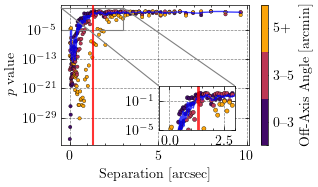

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import numpy as np

# Binning setup
bounds = [0, 3, 5, 8]
labels = ["0–3", "3–5", "5+"]
colors = [mpl.cm.inferno(i) for i in [0.2, 0.5, 0.8]]
cmap = mpl.colors.ListedColormap(colors)
norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(colors))

fig, ax = plt.subplots(figsize=(my_width, my_width / golden))

sc = ax.scatter(
    ks_test_results_df['med_sep'],
    ks_test_results_df['pvalue'],
    c=ks_test_results_df['min_offaxis'],
    cmap=cmap,
    norm=norm,
    edgecolor="black",
    linewidth=0.25,
    s=6
)

# Moving average
ax.plot(
    ks_test_results_df['med_sep'],
    ks_test_results_df['ma_pvalue'],
    color = "blue",
    alpha = 0.75
)

vertical_lines = [ma_sep_10]

for x in vertical_lines:
    ax.axvline(
        x=x,
        linestyle="-",
        linewidth=1.5,
        color="red",
        alpha=0.8,
        zorder=4
    )

# Colorbar
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

bin_centers = [(bounds[i] + bounds[i+1]) / 2 for i in range(len(bounds) - 1)]
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', ticks=bin_centers)
cbar.ax.set_yticklabels(labels)
cbar.set_label(r"Off-Axis Angle [arcmin]")

# Labels and scaling
ax.set_xlabel(r'Separation [arcsec]')
ax.set_ylabel(r'$p$ value')
ax.set_yscale("log")

# ======= ZOOMED INSET AXIS =======
# Define zoom limits
xlim_zoom = (-0.5, 3)
ylim_zoom = (1e-5, 10)

# Inset axis
axins = inset_axes(ax, width="45%", height="35%", loc='lower right',
                   bbox_to_anchor=(0.06, 0.06, 0.9, 0.9),
                   bbox_transform=ax.transAxes)

# Filter data for inset
subset = ks_test_results_df[
    (ks_test_results_df['med_sep'] >= xlim_zoom[0]) &
    (ks_test_results_df['med_sep'] <= xlim_zoom[1]) &
    (ks_test_results_df['pvalue'] >= ylim_zoom[0]) &
    (ks_test_results_df['pvalue'] <= ylim_zoom[1])
]

axins.scatter(
    subset['med_sep'],
    subset['pvalue'],
    c=subset['min_offaxis'],
    cmap=cmap,
    norm=norm,
    edgecolor="black",
    linewidth=0.25,
    s=9
)

# Moving average
axins.plot(
    ks_test_results_df['med_sep'],
    ks_test_results_df['ma_pvalue'],
    color = "blue",
    alpha = 0.75
)

for x in vertical_lines:
    axins.axvline(
        x=x,
        linestyle="-",
        linewidth=2,
        color="red",
        alpha=0.8
    )

axins.set_xlim(xlim_zoom)
axins.set_ylim(ylim_zoom)
axins.set_yscale("log")
axins.set_xlabel('')
axins.set_ylabel('')

mark_inset(ax, axins, loc1=2, loc2=1, fc="none", ec="gray", lw=0.8)

plt.tight_layout()

# Be careful about saving and .gitignore!!
# fig.savefig("ks_test_plot_results.png", dpi=400, bbox_inches='tight')

plt.show()